# CE - 88 Data Science for Smart Cities

**Due date: Monday, November 27th 11:59pm**

## Homework 4

### $k$-Nearest Neighbors


### 1. Conceptual question (20 points)

In figure below, we show a set of training points classified as being either black or white. Consider using the $k$-Nearest Neighbors algorithm to classify new points.


<img src="fig1.png", width="700">



**part 1.** How is the point marked by "?" classified using Euclidean distance as the distance metric for $k = 1,2$ and $3$?<br></br>
ANSWER: k=1 white
k=2 white
k=3 white

**part 2.** Are there any points in the training set that would be misclassified using $k = 1$? If so, identify them. <br></br>
ANSWER: (9,14), (13,18)

**part 3.** Come up with a simple distance metric that would properly classify all the points in the training set for $k = 1$?<br></br>
ANSWER: Distance on x-axis

**part 4.** What happens when $k = 5$ using your distance metric?<br></br>
ANSWER: 7,8,9 => white
12,13 => black

**part 5.** How does your distance metric classify the "?" for $k = 1, 2$ and $3$?<br></br>
ANSWER: all black

In [1]:
# Imports libs and define helper functions
from datascience import *
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

def norm(data):
    x_minus_mean = data - np.mean(data)
    x_norm = x_minus_mean/np.std(data)
    return x_norm

def transform(to_predict, data):
    return (to_predict - np.mean(data))/np.std(data)

def distance(x, y):
    return np.sqrt(np.sum((x-y)**2,1))

def norm_target_based(to_norm_table, input_table, to_norm_name, target_name = 'count'): 
    '''
    Normalize categorical variable based on the target when target variable is numerical.
    <input>
    * (Table) to_norm_table : data to be normed
    * (Table) input_table : training data set
    * (String) to_norm_name : name of the column to be normed, e.g., 'season'
    * (String) target_name: name of the target column, e.g., 'count'
    <output>
    * (ndarray) normalized column values based on input_table
    ''' 
    # Find the unique values of categorical variables
    unique_categories = np.unique(to_norm_table.column(to_norm_name))
    
    # Get average of the target for each category
    avg_each_cat = [np.mean(input_table.where(to_norm_name,category).column(target_name)) 
                    for category in unique_categories]
    
    # Return the normalized to_norm_table
    return transform([avg_each_cat[val-1] for val in to_norm_table.column(to_norm_name)], 
                     input_table.column(to_norm_name))

### 2. $k$-NN vs. linear regression (40 points)

In this question, you will compare the performance of $k$-NN and Linear Regression on prediction of load with respect to temperature readings (same database as homework 2). You are given two databases: (1) "Reg_Training.csv" which contains the data of months June and July in year 2016 for training, and (2) "Reg_Testing.csv", which contains the data of month of August in year 2016 for testing. 

**Part 1.** Fit a line to the training data using any library or formula that you want. Then use the line to predict the power in the testing data. Then compute the least square error of your predictions. For example, if your predictions are $\hat{y_i}$, and the actual power load in the testing data is $y_i$, then the least square error is:

$\frac{1}{N}\sum_{i=1}^{N} (y_i - \hat{y_i})^2$

In [3]:
# Load data
train = Table.read_table("Reg_Training.csv")
test = Table.read_table("Reg_Testing.csv")
test
train

Date,Temperature,Load
2016-06-01,76.0333,1927.88
2016-06-02,75.2,1896.42
2016-06-03,72.8937,1868.29
2016-06-04,73.1875,1652.71
2016-06-05,69.7032,1547.88
2016-06-06,68.2815,1654.88
2016-06-07,63.5219,1538.21
2016-06-08,57.2812,1396.54
2016-06-09,61.525,1425.83
2016-06-10,70.2375,1569.58


In [4]:
# Get linear regression based on training data

# 1) 
x = train["Temperature"]
y = train["Load"]
theta1 = np.sum(x*(y-np.mean(y)))/np.sum(x*(x-np.mean(x)))
theta2 = -theta1*np.mean(x) + np.mean(y)
theta1, theta2

(38.798185464096015, -1026.3416866781085)

In [5]:
# 2) 
X = np.vstack([train["Temperature"], np.ones(len(train.column(0)))]).T
y = train["Load"]
theta = np.linalg.solve(X.T.dot(X), X.T.dot(y))
theta

array([   38.79818546, -1026.34168668])

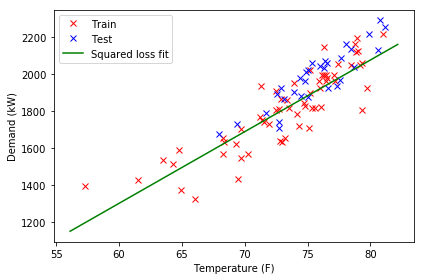

In [6]:
# Visualize the data
plt.plot(train["Temperature"], train["Load"], 'rx')
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.plot(test["Temperature"], test["Load"], 'bx')
plt.plot(xlim, [theta[0]*xlim[0]+theta[1], theta[0]*xlim[1]+theta[1]], 'g-')
plt.legend(["Train", "Test", "Squared loss fit"], loc="upper left")
plt.xlabel("Temperature (F)")
plt.ylabel("Demand (kW)")
plt.tight_layout()

In [7]:
# Get Least Squared Error
LSE = sum((test["Load"]-(theta1*test["Temperature"]+theta2))**2)/test.num_rows
LSE

10410.647756674156

**Part 2.** Implement the $k$-NN method with $k = {1,3,5}$. Use the training data to find the nearest neighbors for each testing data and the predict the power in the testing data. Find the least square error same as above. 

- What is the relationship between error in prediction and $k$? 

- Which method (linear regression or $k$-NN) is performing better? why? 

In [8]:
# Rename the test set not to be confused...
test2 = test.select(["Temperature","Load"])

# Define the function of predicing power load given temperature
def predict_load(input_table, to_predict, k, averaging=True):
    '''
    Predict power load by temperature 
    <input>
    * (Table) input_table : training data set that includes 'Temperature' column 
    * (String) to_predict : point to predict the power load
    * (integer) k : number of neareast neighbors
    * (boolean) averaging : boolean flag to return average power load over k-neighbors
                            if True - return the average power load over k-neighbors
                            if False - return the majority power load over k-neighbors 
                                      (NOTE, it is likely to return the power load of the nearest neighbor
                                             because the power load is continuous value and is quite unlikely 
                                             to have a common value with other neighbors)
    <output>
    * (double) predicted power load
    ''' 
    
    input_data = input_table.select('Temperature').values
    dists = distance(to_predict, input_data)
    inds = np.argsort(dists)[0:k]
    if averaging:
        most_common_response = np.mean(input_table['Load'][inds])
    else:
        most_common_response = np.argmax(np.bincount(list(input_table['Load'][inds])))    
    return most_common_response

# Predict the power load by k and add a new column for the predicted load associated with k
test2['predicted_k1'] = test2.apply(lambda temp: predict_load(train, temp, 1, True),'Temperature')
test2['predicted_k3'] = test2.apply(lambda temp: predict_load(train, temp, 3, True),'Temperature')
test2['predicted_k5'] = test2.apply(lambda temp: predict_load(train, temp, 5, True),'Temperature')

# Compute Least Squared Error
LSE_k1 = sum((test2["Load"]-test2["predicted_k1"])**2)/test2.num_rows
LSE_k3 = sum((test2["Load"]-test2["predicted_k3"])**2)/test2.num_rows
LSE_k5 = sum((test2["Load"]-test2["predicted_k5"])**2)/test2.num_rows

LSE_k1, LSE_k3, LSE_k5

(24500.175011200674, 20626.978320390263, 16065.150573476687)

### 3. $k$-NN for classification (40 points)

In this question, you will use $k$-NN for classification purposes. You are given two databases: (1) "Class_Training.csv" which contains the training data of bike sharing, and (2) "Class_Testing.csv", which contains the testing data of bikesharing. Treat season, weather, temp and hum as features and count as class label. 

Use the training data and implement $k$-NN with $k = {1,3,7}$ to find the class lables for testing data. Plot the relationship between $k$ and the accuracy in predicting the class labels. 



In [9]:
# Load data
train = Table.read_table("Class_Training.csv")
test = Table.read_table("Class_Testing.csv")
train

season,weather,temp,hum,count
3,3,0.56,0.94,1
3,2,0.62,0.94,2
1,1,0.1,0.54,1
3,1,0.66,0.65,1
3,1,0.66,0.74,3
3,1,0.68,0.69,1
2,3,0.42,0.94,1
2,2,0.5,0.94,2
2,3,0.42,0.94,1
2,1,0.32,0.61,1


In [10]:
# Normalize data
normed_train = train.copy(); normed_test = test.copy()

normed_train['season'] = norm_target_based(train,train,'season','count')
normed_train['weather'] = norm_target_based(train,train,'weather','count')
normed_train['temp'] = norm(train['temp'])
normed_train['hum'] = norm(train['hum'])

normed_test['season'] = norm_target_based(test, train,'season','count')
normed_test['weather'] = norm_target_based(test, train,'weather','count')
normed_test['temp'] = transform(test['temp'], train['temp'])
normed_test['hum'] = transform(test['hum'], train['hum'])

normed_train

season,weather,temp,hum,count
-0.0596406,0.134973,0.359739,1.49374,1
-0.0596406,0.763775,0.663104,1.49374,2
-1.0617,1.04183,-1.96605,-0.544175,1
-0.0596406,1.04183,0.865346,0.0162524,1
-0.0596406,1.04183,0.865346,0.474783,3
-0.0596406,1.04183,0.966468,0.220044,1
-0.314954,0.134973,-0.34811,1.49374,1
-0.314954,0.763775,0.0563752,1.49374,2
-0.314954,0.134973,-0.34811,1.49374,1
-0.314954,1.04183,-0.853717,-0.187539,1


In [11]:
normed_test

season,weather,temp,hum,count
-0.328498,0.763775,0.663104,1.49374,3
-0.314954,0.763775,0.561982,-0.0346955,4
-1.0617,1.04183,-0.449232,-1.1046,2
-0.328498,1.04183,-0.752596,0.576679,1
-0.328498,1.04183,0.663104,-0.951758,5
-0.0596406,1.04183,1.26983,-0.697018,2
-0.314954,0.134973,0.258618,0.423836,2
-1.0617,1.04183,-1.46045,-0.0346955,1
-0.0596406,1.04183,1.16871,-0.697018,1
-0.328498,0.763775,-0.0447462,1.49374,3


In [12]:
def predict_count(input_table, to_predict, k):
    input_data = input_table.drop('count').values
    dists = distance(to_predict, input_data)
    inds = np.argsort(dists)[0:k]
    most_common_response = np.argmax(np.bincount(input_table['count'][inds]))
    return most_common_response

# Predict the counts
normed_test['predicted_k1'] = normed_test.apply(lambda season, weather, temp, hum: 
                                              predict_count(normed_train, [season, weather, temp, hum], 1), 
                                              [0,1,2,3])
normed_test['predicted_k3'] = normed_test.apply(lambda season, weather, temp, hum: 
                                              predict_count(normed_train, [season, weather, temp, hum], 3), 
                                              [0,1,2,3])
normed_test['predicted_k7'] = normed_test.apply(lambda season, weather, temp, hum: 
                                              predict_count(normed_train, [season, weather, temp, hum], 7), 
                                              [0,1,2,3])
normed_test

season,weather,temp,hum,count,predicted_k1,predicted_k3,predicted_k7
-0.328498,0.763775,0.663104,1.49374,3,1,1,1
-0.314954,0.763775,0.561982,-0.0346955,4,1,1,1
-1.0617,1.04183,-0.449232,-1.1046,2,1,3,3
-0.328498,1.04183,-0.752596,0.576679,1,3,1,1
-0.328498,1.04183,0.663104,-0.951758,5,6,2,2
-0.0596406,1.04183,1.26983,-0.697018,2,3,3,2
-0.314954,0.134973,0.258618,0.423836,2,1,1,1
-1.0617,1.04183,-1.46045,-0.0346955,1,1,1,1
-0.0596406,1.04183,1.16871,-0.697018,1,3,2,2
-0.328498,0.763775,-0.0447462,1.49374,3,1,1,1


In [13]:
# Calculate accuracy
accuracy_k1 = np.count_nonzero(normed_test.column('count') == normed_test.column('predicted_k1'))/normed_test.num_rows
accuracy_k3 = np.count_nonzero(normed_test.column('count') == normed_test.column('predicted_k3'))/normed_test.num_rows
accuracy_k7 = np.count_nonzero(normed_test.column('count') == normed_test.column('predicted_k7'))/normed_test.num_rows
[accuracy_k1, accuracy_k3, accuracy_k7]

[0.47789855072463766, 0.527536231884058, 0.5427536231884058]

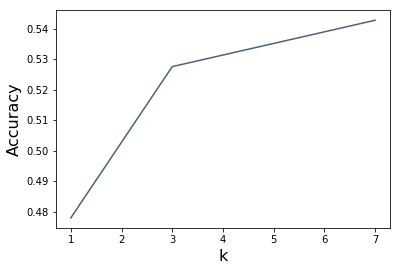

In [14]:
# Visualize the accuracy by k
Table().with_columns("k", make_array(1,3,7), "Accuracy", make_array(accuracy_k1, accuracy_k3, accuracy_k7)).plot(0,1)

# Load OKpy

In [168]:
# from client.api.notebook import Notebook
# ok = Notebook('HW4.ok')
# _ = ok.auth(inline=True)

# Submit to OKpy

In [169]:
# _ = ok.submit()